In [476]:
import numpy as np
import pandas as pd
import sklearn
import catboost
import shap
import seaborn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import OrdinalEncoder
from pandas_profiling import ProfileReport

from IPython.display import display, Markdown

# Problem Statement

Work with the attached dataset to identify users who are more likely to do a sale.

It's important for the business to understand **what makes someone more likely to buy** an insurance.
For this purpose, we assembled a dataset with features of users and their sessions and an indicator if they resulted in a sale or not.

Your goal is to work with this dataset and **identify users who are more likely to convert** so that we can personalise the experience for them.

We don't expect a perfect solution (actually, we believe there isn't one). But please take several hours to implement a well structured approach in a Jupyter notebook.

Afterwards, we'll discuss your solution in detail. Be ready to answer question like, why did you choose this approach and not others, how will you measure the performance of your solution and how do you interpret the final results


# Data understanding

| field name   	| description                                                  	|
|--------------	|--------------------------------------------------------------	|
| id           	| unique identifier of the rows                                	|
| date         	| date of the session                                          	|
| campaign_id  	| id of the advertising campaign that led the user to the site 	|
| group_id     	| id of the group that lead the user to the site               	|
| age_group    	| age range of the user                                        	|
| gender       	| gender of the user                                           	|
| user_type    	| internal id of the type of user                              	|
| platform     	| device type of the user                                      	|
| state_id     	| US state id of the user location                             	|
| interactions 	| number of interactions of the user                           	|
| sale         	| boolean indicator if the user has made a sale or not         	|

## Read-in the data

In [635]:
sales_data = pd.read_csv('sales_data.csv.gz', compression='gzip', sep=',', header=0, index_col=0)

In [636]:
sales_data

,date,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions,sale
id,,,,,,,,,,
277133,2021-05-04,3,372,45-49,F,0,desktop,19,5249,0.0
270342,2021-05-04,3,313,35-39,F,4,desktop,16,1522,0.0
161280,2021-05-02,3,321,30-34,M,1,desktop,25,2,0.0
252773,2021-05-04,3,426,30-34,F,0,NaN,27,2,1.0
118886,2021-05-01,3,337,40-44,M,8,desktop,16,2,0.0
...,...,...,...,...,...,...,...,...,...,...
71168,2021-05-01,3,404,30-34,F,2,NaN,5,2,0.0
8348,2021-05-01,3,329,35-39,F,2,desktop,26,1625,0.0
242565,2021-05-04,3,361,35-39,F,7,desktop,12,2,0.0


In [4]:
"""
sales_data['age_group'] = sales_data['age_group'].astype('category')
sales_data['campaign_id'] = sales_data['campaign_id'].astype('category')
sales_data['group_id'] = sales_data['group_id'].astype('category')
sales_data['user_type'] = sales_data['user_type'].astype('category')
sales_data['state_id'] = sales_data['state_id'].astype('category')
"""

"\nsales_data['age_group'] = sales_data['age_group'].astype('category')\nsales_data['campaign_id'] = sales_data['campaign_id'].astype('category')\nsales_data['group_id'] = sales_data['group_id'].astype('category')\nsales_data['user_type'] = sales_data['user_type'].astype('category')\nsales_data['state_id'] = sales_data['state_id'].astype('category')\n"

In [5]:
profile = ProfileReport(sales_data, title="Sales Data Report", explorative=True, dark_mode=True)

In [6]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

overflow encountered in long_scalars


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# profile.to_notebook_iframe()

**Notes**:

   - missing values in sales. remove from analysis
   - imbalance in sales. need to rebalance
   - missing values in platform. remove?
   - imabalance in platform. rebalance?
   - encode categorical string variables 
   - log transform interactions?
   - reduce cardinatlity of group_id ?

## Clean-up

In [637]:
display(Markdown("### 1. Remove empty sales"))

### 1. Remove empty sales

In [736]:
empty_sales_mask = np.isnan(sales_data['sale'])

sales_data_cleaned = sales_data[~empty_sales_mask].copy()

In [737]:
sales_data_cleaned

,date,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions,sale
id,,,,,,,,,,
277133,2021-05-04,3,372,45-49,F,0,desktop,19,5249,0.0
270342,2021-05-04,3,313,35-39,F,4,desktop,16,1522,0.0
161280,2021-05-02,3,321,30-34,M,1,desktop,25,2,0.0
252773,2021-05-04,3,426,30-34,F,0,NaN,27,2,1.0
118886,2021-05-01,3,337,40-44,M,8,desktop,16,2,0.0
...,...,...,...,...,...,...,...,...,...,...
71168,2021-05-01,3,404,30-34,F,2,NaN,5,2,0.0
8348,2021-05-01,3,329,35-39,F,2,desktop,26,1625,0.0
242565,2021-05-04,3,361,35-39,F,7,desktop,12,2,0.0


In [738]:
sales_data_cleaned=sales_data_cleaned.fillna('not available')

## Log-transform `interactions`

In [739]:
def log_trans(df):    
    df['interactions'] = np.log10(df['interactions'])
    return pd.DataFrame(df, columns=df.columns)


## Re-balancing `sale`

In [740]:
feature_cols = ['campaign_id', 'group_id', 'age_group', 'gender', 'user_type', 'platform', 'state_id', 'interactions']
target_col = ['sale']

In [741]:
sales_data_cleaned[feature_cols]

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
id,,,,,,,,
277133,3,372,45-49,F,0,desktop,19,5249
270342,3,313,35-39,F,4,desktop,16,1522
161280,3,321,30-34,M,1,desktop,25,2
252773,3,426,30-34,F,0,not available,27,2
118886,3,337,40-44,M,8,desktop,16,2
...,...,...,...,...,...,...,...,...
71168,3,404,30-34,F,2,not available,5,2
8348,3,329,35-39,F,2,desktop,26,1625
242565,3,361,35-39,F,7,desktop,12,2


### Random undersampler

In [742]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC

rus = RandomUnderSampler(random_state=42, sampling_strategy=1.0, replacement=True)

In [752]:
X, y = rus.fit_resample(X=sales_data_cleaned[feature_cols],
                       y=sales_data_cleaned[target_col])

In [753]:
X

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
0,3,401,30-34,F,4,not available,32,5381
1,3,423,45-49,F,1,not available,49,1771
2,3,420,35-39,M,2,not available,28,2
3,3,236,40-44,M,1,desktop,20,2
4,3,345,40-44,F,5,desktop,9,2
...,...,...,...,...,...,...,...,...
54987,3,380,30-34,M,5,desktop,20,921
54988,3,469,45-49,M,1,not available,12,777
54989,3,339,40-44,M,0,desktop,14,2
54990,3,296,40-44,F,0,desktop,27,2184


In [754]:
y

,sale
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
54987,1.0
54988,1.0
54989,1.0
54990,1.0


In [755]:
y.groupby(by='sale').size()

sale
0.0    27496
1.0    27496
dtype: int64

## Data Preparation Pipeline

In [784]:
def reduce_column(df, column, q):  
    
    column_freqs = pd.DataFrame(df[column].value_counts())
    column_freqs = column_freqs.reset_index().rename(columns={'index': column,
                                                               column: 'count'})
    
    
    quantile = np.int(np.floor(np.quantile(column_freqs['count'], q=q/100)))
    threshold_mask = column_freqs['count'] > quantile
    
    
    df[column] = np.where(df[column].isin(column_freqs[~threshold_mask][column]), 'Other', df[column])
    
    return pd.DataFrame(df, columns=df.columns)

In [796]:
# the last two steps are optional, comment out if needed
data_preparation_pipeline = Pipeline([
    ("log_trans_interactions", FunctionTransformer(log_trans)),
    ("reduce_group_id", FunctionTransformer(reduce_column, kw_args={'q': 99, 'column': 'group_id'})),
    ("reduce_user_type", FunctionTransformer(reduce_column, kw_args={'q': 80, 'column': 'user_type'}))            
])


In [797]:
X_processed = data_preparation_pipeline.fit_transform(X.copy())

In [798]:
X_processed

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
0,3,401,30-34,F,4,not available,32,3.730863
1,3,Other,45-49,F,1,not available,49,3.248219
2,3,Other,35-39,M,2,not available,28,0.301030
3,3,Other,40-44,M,1,desktop,20,0.301030
4,3,Other,40-44,F,Other,desktop,9,0.301030
...,...,...,...,...,...,...,...,...
54987,3,Other,30-34,M,Other,desktop,20,2.964260
54988,3,Other,45-49,M,1,not available,12,2.890421
54989,3,Other,40-44,M,0,desktop,14,0.301030
54990,3,Other,40-44,F,0,desktop,27,3.339253


In [799]:
categorical_columns = X_processed.columns[:-1]

In [800]:
for col in categorical_columns:
    # all, but the last one 'interactions'
    X_processed[col] = X_processed[col].astype('str')

In [801]:
campaign_id_cats = list(X_processed['campaign_id'].value_counts().index)
group_id_cats = list(X_processed['group_id'].value_counts().index)
age_group_cats = list(X_processed['age_group'].value_counts().index)
gender_cats = list(X_processed['gender'].value_counts().index)
user_type_cats = list(X_processed['user_type'].value_counts().index)
platform_cats = list(X_processed['platform'].value_counts().index)
state_id_cats = list(X_processed['state_id'].value_counts().index)

In [813]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories=[campaign_id_cats,
                                group_id_cats,
                                age_group_cats,
                                gender_cats,
                                user_type_cats,
                                platform_cats,
                                state_id_cats],
                    drop='first', sparse=False)

encoder = ColumnTransformer([('cat', enc, categorical_columns)],
                                  remainder='passthrough')

encoding_pipeline = Pipeline([("one_hot_encoding", encoder)])

## Train - Test Split

In [814]:
from sklearn.model_selection import train_test_split

In [815]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    stratify=y)

------

# Modelling

## Baseline Models

### Statsmodels Logistics Regression

In [816]:
sm_train_data = X_train.join(y_train)
sm_test_data = X_test.join(y_test)

In [817]:
formula = ('sale ~ C(campaign_id, Treatment(reference="3")) + '
           'C(group_id, Treatment(reference="403")) + '
           'C(age_group, Treatment(reference="35-39")) + '
           'C(gender, Treatment(reference="F")) + '
           'C(user_type, Treatment(reference=0)) +'
           'C(platform, Treatment(reference="desktop")) + '
           'C(state_id, Treatment(reference=16)) + '
           'interactions')

log_reg_sm = smf.logit(formula=formula, data=sm_train_data).fit()

Optimization terminated successfully.
         Current function value: 0.655034
         Iterations 5


In [818]:
odds_ratios = pd.DataFrame(
    {
        "OR": log_reg_sm.params,
        "Lower CI": log_reg_sm.conf_int()[0],
        "Upper CI": log_reg_sm.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)

odds_ratios["p-values"] = log_reg_sm.pvalues

In [819]:
odds_ratios[odds_ratios['p-values'] < 0.01]

,OR,Lower CI,Upper CI,p-values
Intercept,2.111591,1.530296,2.913695,5.368792e-06
"C(campaign_id, Treatment(reference=""3""))[T.2]",1.470774,1.315305,1.644619,1.304902e-11
"C(age_group, Treatment(reference=""35-39""))[T.30-34]",0.811350,0.758740,0.867607,9.843498e-10
"C(age_group, Treatment(reference=""35-39""))[T.40-44]",1.751053,1.632349,1.878389,3.785508e-55
"C(age_group, Treatment(reference=""35-39""))[T.45-49]",1.919334,1.801680,2.044672,9.726874e-91
"C(gender, Treatment(reference=""F""))[T.M]",0.675162,0.644417,0.707373,2.684730e-61
"C(state_id, Treatment(reference=16))[T.0]",0.221772,0.155789,0.315702,6.333882e-17
"C(state_id, Treatment(reference=16))[T.1]",0.267550,0.198407,0.360790,5.482969e-18
"C(state_id, Treatment(reference=16))[T.10]",0.294291,0.240280,0.360443,2.947100e-32
"C(state_id, Treatment(reference=16))[T.11]",0.231453,0.170001,0.315119,1.473315e-20


### Logistics Regression

In [820]:
from sklearn.linear_model import LogisticRegression

clf_log_reg = LogisticRegression(penalty='l2',
                                 random_state=42,
                                 class_weight='balanced',
                                 max_iter=300, n_jobs=-1)

lr_pipe = Pipeline(encoding_pipeline.steps + [("lr_classifier", clf_log_reg)])



parameters = {'lr_classifier__C': [0.05, 0.1, 0.5, 1], 'lr_classifier__tol': [0.0001, 0.001]}

clf_grid_search = GridSearchCV(lr_pipe,
                               param_grid=parameters,
                               scoring='f1',
                               refit=True,
                               cv=5,
                               n_jobs=-1,
                               verbose=0)

In [821]:
clf_grid_search.fit(X_train, y_train['sale']);

In [822]:
best_score_lr_training = clf_grid_search.best_score_
best_estimator_lr = clf_grid_search.best_estimator_

In [823]:
best_score_lr_training

0.6191536655900101

### Random Forest Classifier

In [824]:
from sklearn.ensemble import RandomForestClassifier

In [825]:
clf_rf = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

parameters = {'rf_classifier__n_estimators': [1000]}

rf_pipe = Pipeline(encoding_pipeline.steps + [("rf_classifier", clf_rf)])

In [826]:
rf_pipe.fit(X_train, y_train['sale']);

### Comparison

In [855]:
pos_label_index_lr = np.where(best_estimator_lr['lr_classifier'].classes_ == 1)[0]
pos_label_index_rf = np.where(rf_pipe['rf_classifier'].classes_ == 1)[0]

In [965]:
y_pred_lr = best_estimator_lr.predict_proba(X_test)[:,pos_label_index_lr]
y_pred_rf = rf_pipe.predict_proba(X_test)[:,pos_label_index_rf]
y_pred_sm = log_reg_sm.predict(sm_test_data)

**Feature Importance**

In [828]:
def plot_feature_importance(estimator, X, y, label='Permutation Importances (test set)'):

    result = permutation_importance(estimator, X, y,
                                    scoring='f1',
                                    n_repeats=20, random_state=42, n_jobs=-1)
    result['importances_mean']
    
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots()
    ax.boxplot(
        result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx]
    )
    ax.set_title(label)
    fig.tight_layout()
    plt.show()

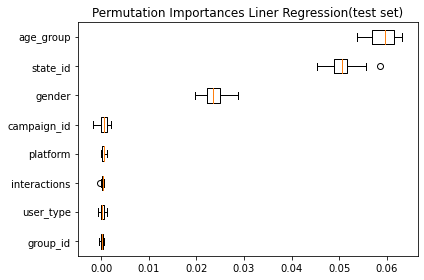

In [829]:
plot_feature_importance(best_estimator_lr, X_test, y_test, label='Permutation Importances Liner Regression(test set)')

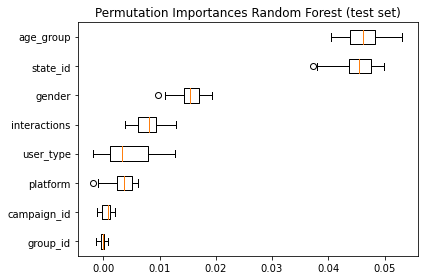

In [830]:
plot_feature_importance(rf_pipe, X_test, y_test, label='Permutation Importances Random Forest (test set)')

**F1 Score**

In [831]:
score_lr = f1_score(y_test['sale'], best_estimator_lr.predict(X_test))
score_rf = f1_score(y_test['sale'], rf_pipe.predict(X_test))
score_sm = f1_score(y_test['sale'], 1 * (y_pred_sm > 0.5))

In [832]:
score_lr

0.6265540067811206

In [833]:
score_rf

0.5789502430498662

In [834]:
score_sm

0.6267291027504172

In [835]:
f1scores_lr = []
f1scores_rf = []
f1scores_sm = []

max_f1 = -10
max_th = -10

for th in np.linspace(0, 1, 9):
    f1_lr = f1_score(y_test['sale'], 1 * (y_pred_lr > th))
    f1_rf = f1_score(y_test['sale'], 1 * (y_pred_rf > th))
    f1_sm = f1_score(y_test['sale'], 1 * (y_pred_sm > th))
    
    if f1_lr > max_f1:
        max_f1 = f1_lr
        max_th = th
        
    if f1_rf > max_f1:
        max_f1 = f1_rf
        max_th = th
        
    if f1_sm > max_f1:
        max_f1 = f1_sm
        max_th = th
        
    f1scores_sm.append(f1_sm)
    f1scores_lr.append(f1_lr)
    f1scores_rf.append(f1_rf)

In [836]:
max_th

0.375

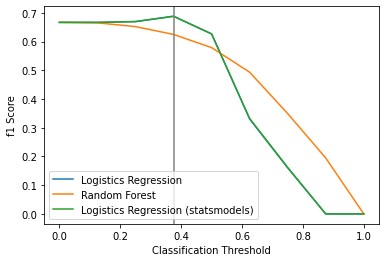

In [837]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_lr, estimator=None, ax=axes, label='Logistics Regression');
seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_rf, estimator=None, ax=axes, label='Random Forest');
seaborn.lineplot(x=np.linspace(0, 1, 9), y=f1scores_sm, estimator=None, ax=axes,
                 label='Logistics Regression (statsmodels)');
plt.axvline(x=max_th, color='grey')


plt.xlabel('Classification Threshold');
plt.ylabel('f1 Score');


**ROC Curve**

In [839]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)

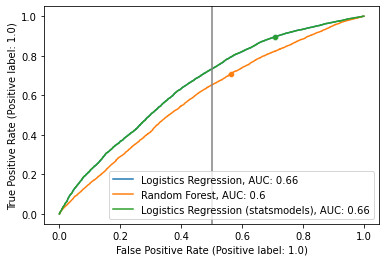

In [841]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes, label=f'Logistics Regression, AUC: {auc_lr}');
seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes, label=f'Random Forest, AUC: {auc_rf}');
seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');

idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[fpr_lr[idx_lr]], y=[tpr_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[fpr_rf[idx_rf]], y=[tpr_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[fpr_sm[idx_sm]], y=[tpr_sm[idx_sm]], ax=axes)

plt.axvline(x=0.5, color='grey')

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


**PR Curve**

In [842]:
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test, y_pred_lr)
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
precisions_sm, recalls_sm, thresholds_sm = precision_recall_curve(y_test, y_pred_sm)

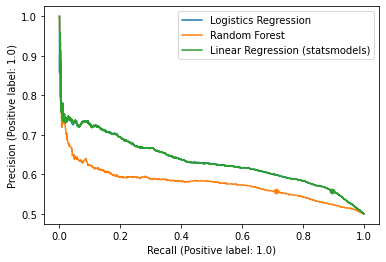

In [843]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=recalls_lr, y=precisions_lr,
                 estimator=None, ax=axes, label=f'Logistics Regression');
seaborn.lineplot(x=recalls_rf, y=precisions_rf,
                 estimator=None, ax=axes, label=f'Random Forest');
seaborn.lineplot(x=recalls_sm, y=precisions_sm,
                 estimator=None, ax=axes, label=f'Linear Regression (statsmodels)');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[recalls_lr[idx_lr]], y=[precisions_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[recalls_rf[idx_rf]], y=[precisions_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[recalls_sm[idx_sm]], y=[precisions_sm[idx_sm]], ax=axes)

plt.xlabel('Recall (Positive label: 1.0)');
plt.ylabel('Precision (Positive label: 1.0)');


## Challenger Model

In [844]:
X_train

,campaign_id,group_id,age_group,gender,user_type,platform,state_id,interactions
49119,3,Other,45-49,F,3,desktop,27,3.517987
46749,3,Other,30-34,F,Other,desktop,28,3.531990
35549,3,Other,40-44,F,Other,desktop,10,0.301030
29284,3,Other,45-49,F,Other,not available,22,0.301030
6868,3,Other,35-39,F,0,desktop,16,4.069742
...,...,...,...,...,...,...,...,...
51523,3,Other,30-34,F,4,not available,22,0.301030
18250,3,Other,35-39,F,2,not available,27,3.472171
3800,3,Other,45-49,F,Other,desktop,2,2.392697
50575,2,Other,40-44,F,3,desktop,12,0.301030


In [857]:
from catboost import CatBoostClassifier, Pool, cv

cat_features = [0, 1, 2, 3, 4, 5, 6]

train_dataset = Pool(data=X_train, label=y_train['sale'], cat_features=cat_features)
test_dataset = Pool(data=X_test, label=y_test['sale'], cat_features=cat_features)

In [957]:
clf = CatBoostClassifier(depth=5,
                         iterations=1000,
                         l2_leaf_reg=1,
                         loss_function="Logloss",
                         eval_metric="F1",
                         logging_level='Silent',
                         boost_from_average=True,
                         langevin=True)

In [958]:
clf.fit(train_dataset)

In [962]:
pos_label_index_cb = np.where(clf.classes_ == 1)[0]

y_pred_cb = clf.predict_proba(test_dataset)[:,pos_label_index_cb]

In [963]:
score_cb = f1_score(test_dataset.get_label(),
                    clf.predict(test_dataset))

In [964]:
score_cb

0.6479591836734694

In [966]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
fpr_sm, tpr_sm, thresholds_sm = roc_curve(y_test, y_pred_sm)
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_pred_cb)

auc_lr = np.round(roc_auc_score(y_test, y_pred_lr), 2)
auc_rf = np.round(roc_auc_score(y_test, y_pred_rf), 2)
auc_sm = np.round(roc_auc_score(y_test, y_pred_sm), 2)
auc_cb = np.round(roc_auc_score(y_test, y_pred_cb), 2)

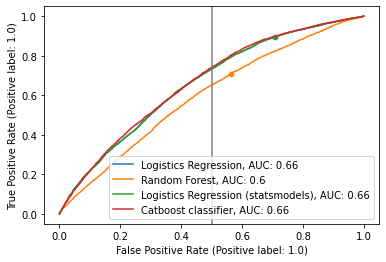

In [967]:
f, axes = plt.subplots(1,1)

seaborn.lineplot(x=fpr_lr, y=tpr_lr, estimator=None, ax=axes, label=f'Logistics Regression, AUC: {auc_lr}');
seaborn.lineplot(x=fpr_rf, y=tpr_rf, estimator=None, ax=axes, label=f'Random Forest, AUC: {auc_rf}');
seaborn.lineplot(x=fpr_sm, y=tpr_sm, estimator=None, ax=axes,
                 label=f'Logistics Regression (statsmodels), AUC: {auc_sm}');
seaborn.lineplot(x=fpr_cb, y=tpr_cb, estimator=None, ax=axes,
                 label=f'Catboost classifier, AUC: {auc_cb}');


idx_lr = np.abs(thresholds_lr-max_th).argmin()
idx_rf = np.abs(thresholds_rf-max_th).argmin()
idx_sm = np.abs(thresholds_sm-max_th).argmin()


seaborn.scatterplot(x=[fpr_lr[idx_lr]], y=[tpr_lr[idx_lr]], ax=axes)
seaborn.scatterplot(x=[fpr_rf[idx_rf]], y=[tpr_rf[idx_rf]], ax=axes)
seaborn.scatterplot(x=[fpr_sm[idx_sm]], y=[tpr_sm[idx_sm]], ax=axes)

plt.axvline(x=0.5, color='grey')

plt.xlabel('False Positive Rate (Positive label: 1.0)');
plt.ylabel('True Positive Rate (Positive label: 1.0)');


In [977]:
clf.get_feature_importance(data=test_dataset, type='PredictionValuesChange', prettified=True)

,Feature Id,Importances
0,state_id,38.595351
1,age_group,36.779171
2,gender,10.873863
3,interactions,5.285469
4,campaign_id,3.236227
5,user_type,2.004918
6,platform,1.845487
7,group_id,1.379513


# Explainability

# Fairness